# 6.6 Sourcing & Analysing Time Series Data

## This script contains the following:
#### 1. Importing libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Data

## 1. Importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings

In [2]:
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [3]:
# configure API key 
quandl.ApiConfig.api_key = 'ADykUXJnySJHWJC4Sv3N'

In [4]:
# import S & P 500 Ratio data
data = quandl.get('FRED/NROU')

In [5]:
data.head()

,Value
Date,
1949-01-01,5.255053
1949-04-01,5.261516
1949-07-01,5.268013
1949-10-01,5.274564
1950-01-01,5.281182


In [6]:
data.shape

(332, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

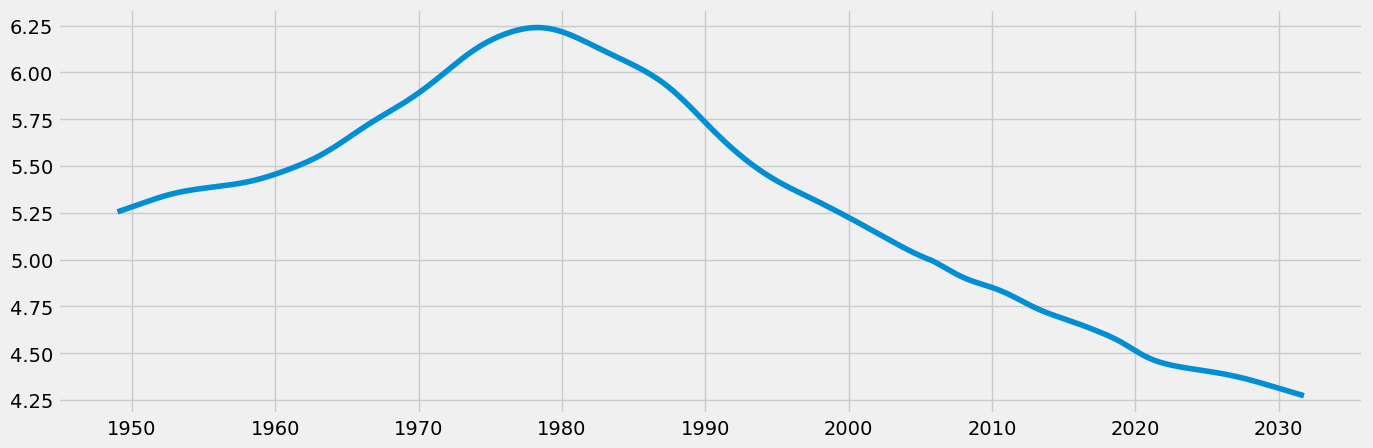

In [8]:
# plotting data using matplotlib
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

## 2. Subsetting, wrangling, and cleaning time-series data

In [9]:
# reset index so that date column can be used as a filter
data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1949-01-01,5.255053
1,1949-04-01,5.261516
2,1949-07-01,5.268013
3,1949-10-01,5.274564
4,1950-01-01,5.281182


In [11]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2022-12-01')]

#### Subset was created to reflect more recent dates up until the present. The earlier dates may serve as a control.

In [12]:
data_sub.shape

(172, 2)

In [13]:
data_sub.head()

,Date,Value
124,1980-01-01,6.217371
125,1980-04-01,6.210709
126,1980-07-01,6.203388
127,1980-10-01,6.195496
128,1981-01-01,6.187123


In [14]:
# set the "Date" column as the index
from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,6.217371
1980-04-01,6.210709
1980-07-01,6.203388
1980-10-01,6.195496
1981-01-01,6.187123


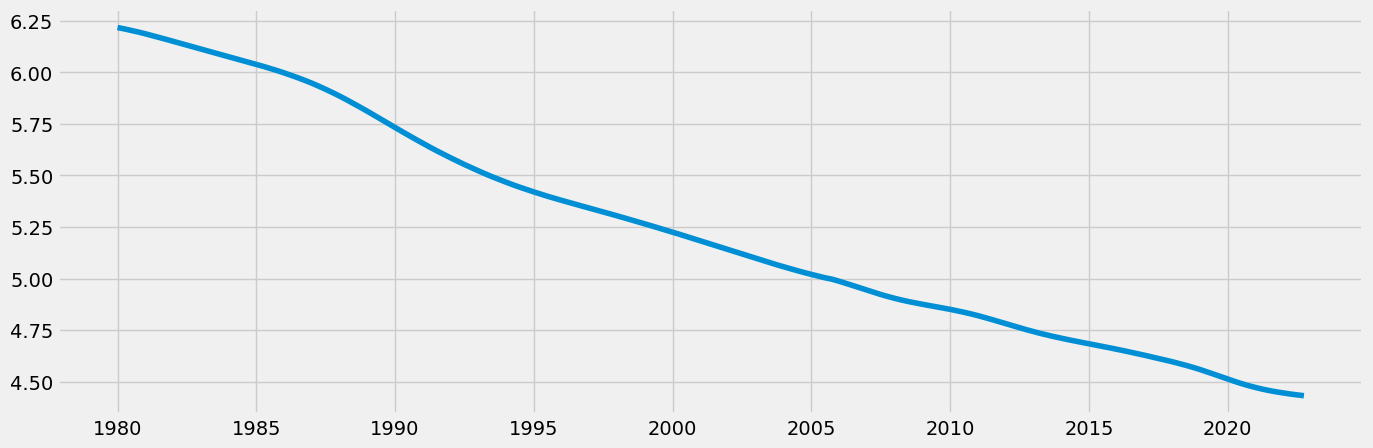

In [15]:
# plot the new data set
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [16]:
# check for missing values
data_sub.isnull().sum() 

Value    0
dtype: int64

In [17]:
# check for duplicates
dups = data_sub.duplicated()
dups.sum()

0

## 3. Decomposition

In [39]:
# decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [40]:
from pylab import rcParams 
rcParams['figure.figsize'] = 18, 7

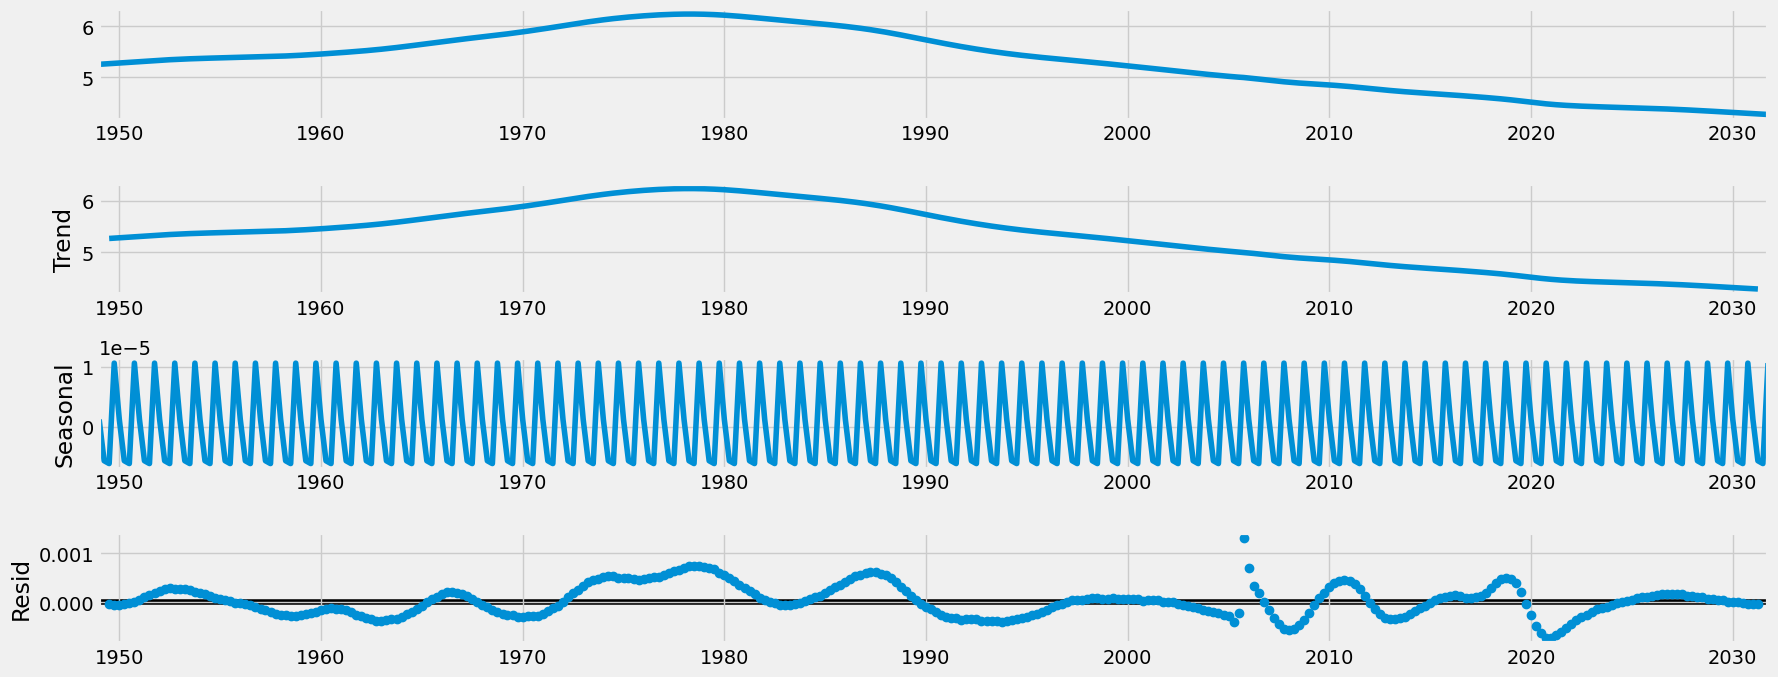

In [41]:
# plot the separate components
decomposition.plot()
plt.show()

### Because I am working with smoothed data, the trend and the level appear the same. The graph had a positive trend until around 1980, and then the trend drops after that and remained negatively trending. Also, there appears to be a seaonsality component to the data as well.

## 4. Tesing for stationarity

In [42]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.745331
p-value                          0.407921
Number of Lags Used              4.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


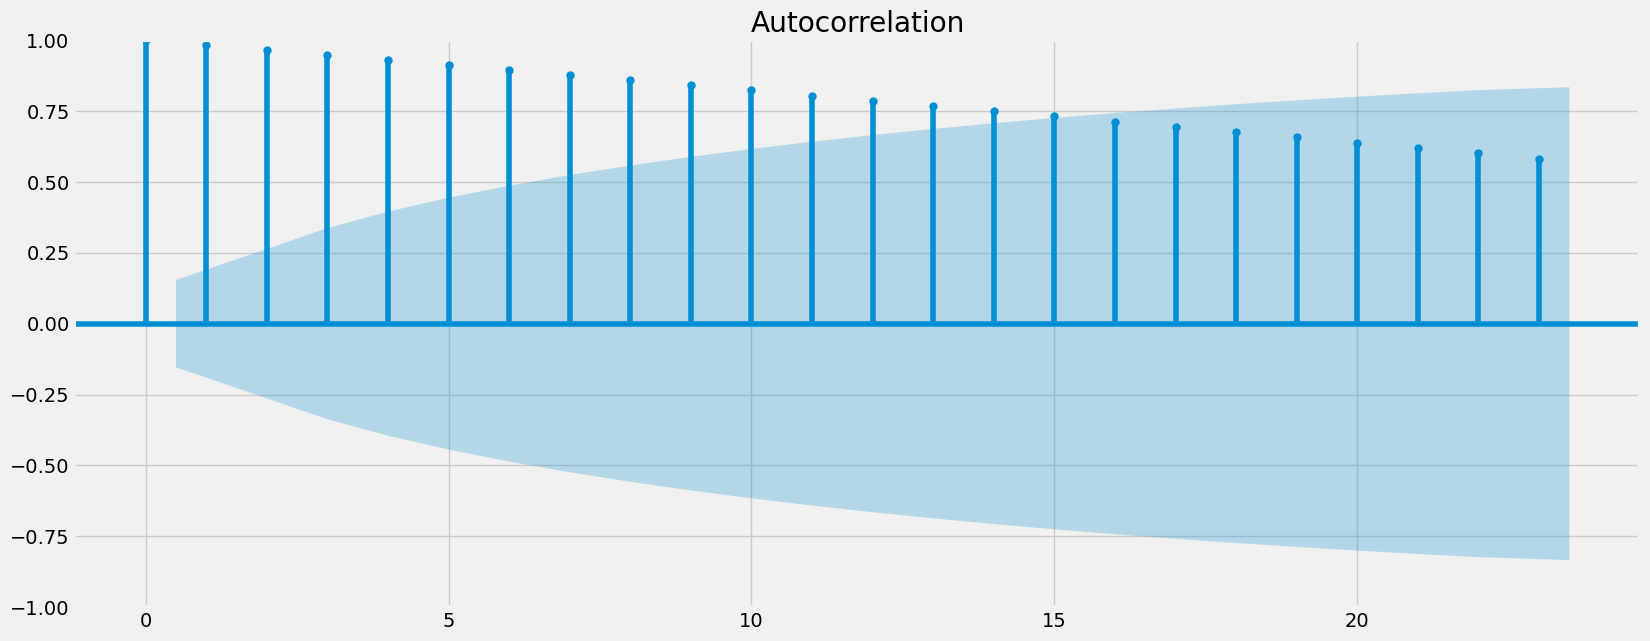

In [43]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### Based on the test statistic being significantly larger that all of the critical value's, we can not reject the null hypothesis. The data therefore is not stationary.

## 5. Stationizing the data

In [44]:
data_diff = data_sub - data_sub.shift(1)

In [45]:
data_diff.dropna(inplace = True)

In [46]:
data_diff.head()

,Value
datetime,
1980-04-01,-0.006662
1980-07-01,-0.007321
1980-10-01,-0.007892
1981-01-01,-0.008373
1981-04-01,-0.008762


In [47]:
data_diff.columns

Index(['Value'], dtype='object')

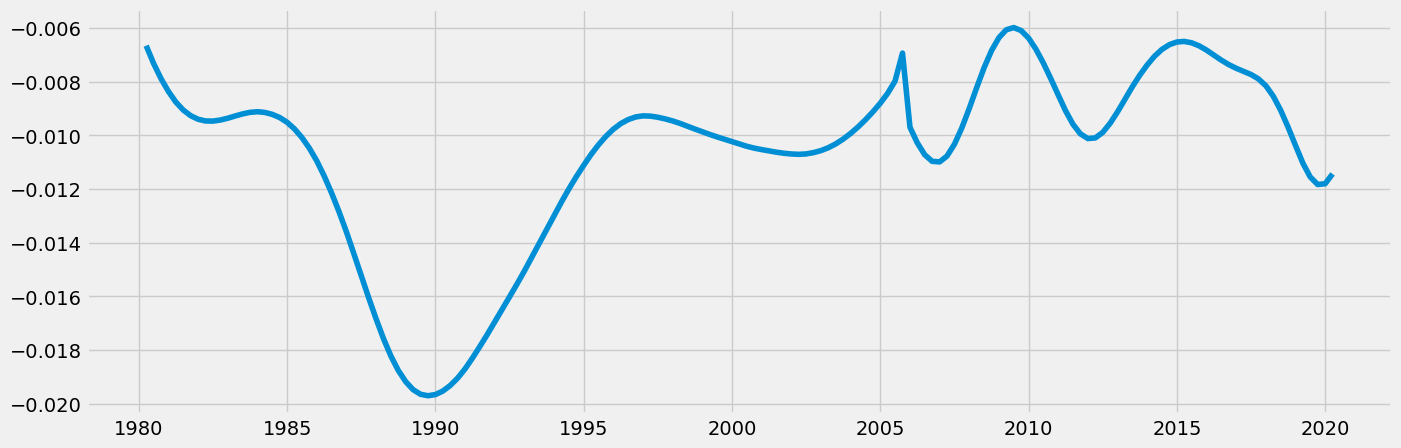

In [48]:
# Check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [49]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.451840
p-value                          0.127636
Number of Lags Used              2.000000
Number of Observations Used    158.000000
Critical Value (1%)             -3.472431
Critical Value (5%)             -2.880013
Critical Value (10%)            -2.576619
dtype: float64


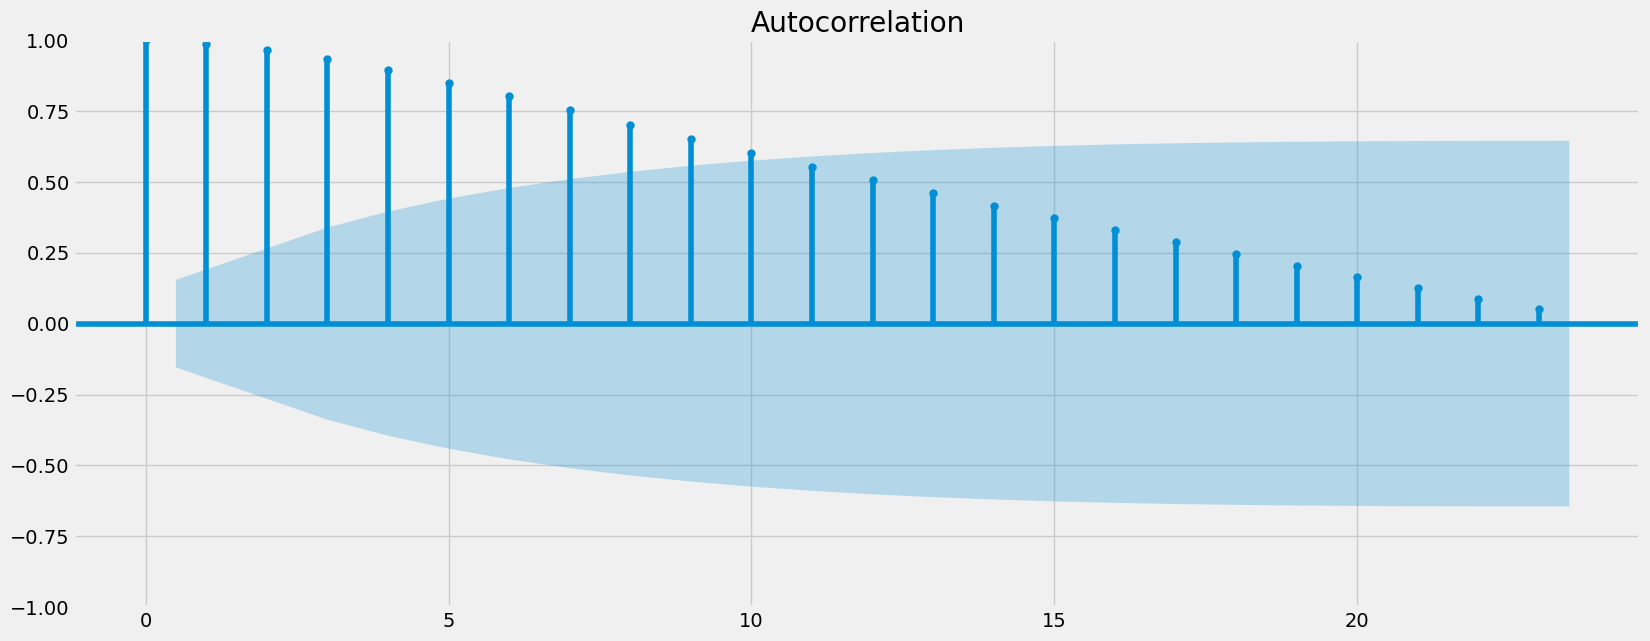

In [50]:
plot_acf(data_diff)
plt.show()

### The data has now been made stationary.